In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cài đặt thư viện cần thiết
!pip install transformers torch
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Tải PhoBERT
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertForSequenceClassification
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
#import warnings
#warnings.filterwarnings("ignore")

# Tải tokenizer và model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Đọc dữ liệu từ tệp
sents = open(r"/content/drive/MyDrive/VSFC/train/sents.txt", "r").read().splitlines()
sentiments = open(r"/content/drive/MyDrive/VSFC/train/sentiments.txt", "r").read().splitlines()
topics = open(r"/content/drive/MyDrive/VSFC/train/topics.txt", "r").read().splitlines()

df = pd.DataFrame({"text": sents, "sentiment": sentiments, "topic": topics})
print(df.head())

                                                text sentiment topic
0                          slide giáo trình đầy đủ .         2     1
1     nhiệt tình giảng dạy , gần gũi với sinh viên .         2     0
2               đi học đầy đủ full điểm chuyên cần .         0     1
3  chưa áp dụng công nghệ thông tin và các thiết ...         0     0
4  thầy giảng bài hay , có nhiều bài tập ví dụ ng...         2     0


<ipython-input-7-f62693033ccf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="viridis")


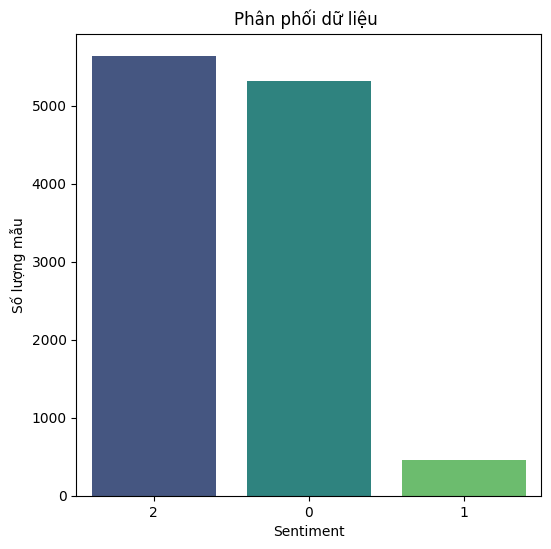

Phân phối sentiment:
 sentiment
2    5643
0    5325
1     458
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
# Kiểm tra phân phối sentiment

plt.figure(figsize=(6, 6))
sns.countplot(x="sentiment", data=df, palette="viridis")
plt.title("Phân phối dữ liệu ")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.show()
print("Phân phối sentiment:\n", df["sentiment"].value_counts())

In [8]:
# Cân bằng dữ liệu bằng oversampling
max_size = df["sentiment"].value_counts().max()  # Lấy số lượng mẫu của lớp lớn nhất
df_list = []
for sentiment in df["sentiment"].unique():  # Duyệt qua từng lớp cảm xúc
    df_class = df[df["sentiment"] == sentiment]  # Lấy dữ liệu của lớp đó
    df_class_oversampled = resample(df_class, replace=True, n_samples=max_size, random_state=42)  # Oversampling: sao chép ngẫu nhiên để đạt số lượng bằng max_size
    df_list.append(df_class_oversampled)  # Thêm dữ liệu đã oversampling vào danh sách
df_balanced = pd.concat(df_list)  # Kết hợp các DataFrame đã cân bằng
print("Phân phối sentiment:\n", df_balanced["sentiment"].value_counts())  # Kiểm tra lại phân phối sau khi cân bằng

Phân phối sentiment:
 sentiment
2    5643
0    5643
1    5643
Name: count, dtype: int64


<ipython-input-9-993b97f97660>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df_balanced, palette="viridis")


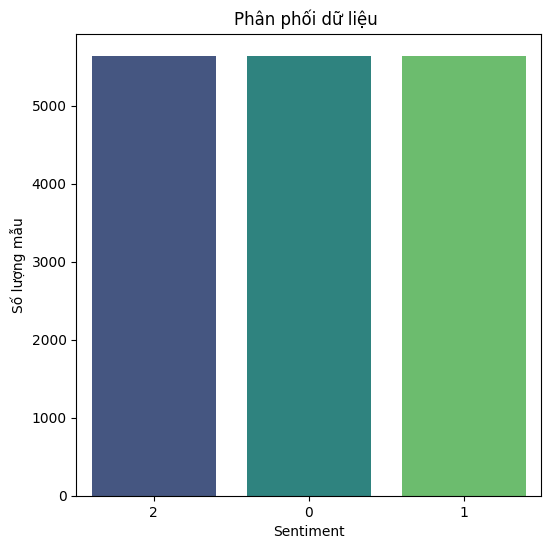

Phân phối sentiment:
 sentiment
2    5643
0    5643
1    5643
Name: count, dtype: int64


In [9]:
plt.figure(figsize=(6, 6))
sns.countplot(x="sentiment", data=df_balanced, palette="viridis")
plt.title("Phân phối dữ liệu ")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.show()
print("Phân phối sentiment:\n", df_balanced["sentiment"].value_counts())

In [10]:
# Chuyển dữ liệu thành DataFrame
df["sentiment"] = df["sentiment"].astype(int)
df["text"] = df["text"].apply(lambda x: word_tokenize(x, format="text"))
print(df.head())

                                                text  sentiment topic
0                          slide giáo_trình đầy_đủ .          2     1
1     nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .          2     0
2               đi học đầy_đủ full_điểm chuyên cần .          0     1
3  chưa áp_dụng công_nghệ_thông_tin và các thiết_...          0     0
4  thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...          2     0


In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42 )

In [12]:
# Tải lại tokenizer (để đảm bảo không có lỗi)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Hàm tokenize để mã hóa văn bản thành định dạng mà PhoBERT có thể hiểu
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)  # padding và cắt câu để độ dài tối đa là 128 token

# Tokenize dữ liệu huấn luyện và kiểm tra
train_encodings = tokenize_function(train_texts.tolist())
val_encodings = tokenize_function(val_texts.tolist())

In [13]:
# Định nghĩa lớp Dataset để PyTorch có thể làm việc với dữ liệu
class PhoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):  # Khởi tạo với encodings (dữ liệu mã hóa) và labels (nhãn)
        self.encodings = encodings
        self.labels = labels

    def __len__(self):  # Trả về số lượng mẫu trong tập dữ liệu
        return len(self.labels)

    def __getitem__(self, idx):  # Truy xuất một mẫu dữ liệu tại vị trí idx
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Chuyển dữ liệu mã hóa thành tensor
        item["labels"] = torch.tensor(self.labels[idx])  # Thêm nhãn vào, cũng chuyển thành tensor
        return item

# Tạo Dataset cho tập huấn luyện và kiểm tra
train_dataset = PhoBERTDataset(train_encodings, train_labels.tolist())
val_dataset = PhoBERTDataset(val_encodings, val_labels.tolist())

In [14]:
os.environ["WANDB_MODE"] = "disabled"

In [16]:
from sklearn.metrics import recall_score
# Tải lại mô hình PhoBERT để huấn luyện
model = BertForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=df["sentiment"].nunique())  # Tải mô hình với số lớp bằng số lớp cảm xúc

# Cấu hình tham số huấn luyện
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results",  # Thư mục lưu kết quả huấn luyện
    eval_strategy="epoch",  # Đánh giá sau mỗi epoch
    learning_rate=5e-5,  # Tốc độ học
    per_device_train_batch_size=16,  # Kích thước batch cho huấn luyện
    per_device_eval_batch_size=1616,  # Kích thước batch cho đánh giá
    num_train_epochs=5,  # Số epoch huấn luyện
    weight_decay=0.01,  # Tham số điều chuẩn để tránh overfitting
    logging_steps=50,  # Ghi log sau mỗi 50 bước
    report_to="none",  # Không ghi log ra ngoài
    save_total_limit=1,  # Chỉ lưu 1 checkpoint
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    load_best_model_at_end=True,  # Tải mô hình tốt nhất sau khi huấn luyện xong
    metric_for_best_model="recall",  # Sử dụng recall để chọn mô hình tốt nhất
)

# Định nghĩa hàm tính recall để đánh giá mô hình
def compute_metrics(p):
    pred, labels = p  # Lấy dự đoán và nhãn thật
    pred = np.argmax(pred, axis=1)  # Chuyển logits thành nhãn dự đoán
    recall = recall_score(labels, pred, average='macro')  # Tính recall trung bình theo từng lớp
    return {"recall": recall}

# Khởi tạo Trainer để quản lý quá trình huấn luyện
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Huấn luyện mô hình
try:
    trainer.train()  # Bắt đầu huấn luyện
except Exception as e:
    print(f"Huấn luyện thất bại với lỗi: {e}")  # In lỗi nếu huấn luyện thất bại

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attenti

Epoch,Training Loss,Validation Loss,Recall
1,0.422700,0.383056,0.618068
2,0.330400,0.407085,0.635642
3,0.320000,0.355815,0.663451
4,0.295600,0.391629,0.679245
5,0.170300,0.369037,0.730303


In [17]:
#Lưu mô hình và tokenizer đã huấn luyện
model.save_pretrained("/content/drive/MyDrive/results/final_model")
tokenizer.save_pretrained("/content/drive/MyDrive/results/final_model")

('/content/drive/MyDrive/results/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/results/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/results/final_model/vocab.txt',
 '/content/drive/MyDrive/results/final_model/bpe.codes',
 '/content/drive/MyDrive/results/final_model/added_tokens.json')

In [19]:
# Đọc dữ liệu test từ các tệp
sents_test = open(r"/content/drive/MyDrive/VSFC/test/sents.txt", "r").read().splitlines()  # Đọc câu văn
sentiments_test = open(r"/content/drive/MyDrive/VSFC/test/sentiments.txt", "r").read().splitlines()  # Đọc nhãn cảm xúc
topics_test = open(r"/content/drive/MyDrive/VSFC/test/topics.txt", "r").read().splitlines()  # Đọc nhãn chủ đề

# Tạo DataFrame cho dữ liệu test
df_test = pd.DataFrame({"text": sents_test, "sentiment": sentiments_test, "topic": topics_test})
df_test["sentiment"] = df_test["sentiment"].astype(int)  # Chuyển nhãn cảm xúc sang kiểu số nguyên
print("Test Data Head:")
print(df_test.head())  # In 5 dòng đầu của dữ liệu test

# Tiền xử lý dữ liệu test: tách từ tiếng Việt
df_test["text"] = df_test["text"].apply(lambda x: word_tokenize(x, format="text"))

# Tokenize dữ liệu test
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

test_encodings = tokenize_function(df_test["text"].tolist())  # Mã hóa dữ liệu test

# Tạo Dataset cho dữ liệu test (tương tự như tập huấn luyện và kiểm tra)
class PhoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

test_dataset = PhoBERTDataset(test_encodings, df_test["sentiment"].tolist())

# Dự đoán trên tập test
predictions = trainer.predict(test_dataset)  # Sử dụng Trainer để dự đoán

# Lấy nhãn dự đoán từ logits
predicted_labels = np.argmax(predictions.predictions, axis=-1)  # Chuyển logits thành nhãn (0, 1, 2)
true_labels = predictions.label_ids  # Lấy nhãn thật từ test_dataset

# Tính toán và in các chỉ số đánh giá
accuracy = accuracy_score(true_labels, predicted_labels)  # Tính độ chính xác
report = classification_report(true_labels, predicted_labels)  # Tạo báo cáo chi tiết (precision, recall, F1-score)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Test Data Head:
                                                text  sentiment topic
0                           nói tiếng anh lưu loát .          2     0
1                           giáo viên rất vui tính .          2     0
2                                    cô max có tâm .          2     0
3                       giảng bài thu hút , dí dỏm .          2     0
4  giáo viên không giảng dạy kiến thức , hướng dẫ...          0     0


Accuracy: 0.8894504106127605
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1409
           1       0.43      0.26      0.32       167
           2       0.93      0.91      0.92      1590

    accuracy                           0.89      3166
   macro avg       0.74      0.70      0.72      3166
weighted avg       0.88      0.89      0.88      3166



In [20]:
# Đánh giá lại mô hình trên tập kiểm tra (val_dataset)
trainer.evaluate()

{'eval_loss': 0.3690367043018341,
 'eval_recall': 0.730303397990208,
 'eval_runtime': 14.8274,
 'eval_samples_per_second': 154.174,
 'eval_steps_per_second': 0.135,
 'epoch': 5.0}

In [23]:
# Kiểm tra các tệp trong thư mục mô hình đã lưu
!ls /content/drive/MyDrive/results/final_model

# Giải phóng bộ nhớ GPU
torch.cuda.empty_cache()

added_tokens.json  config.json	      special_tokens_map.json  vocab.txt
bpe.codes	   model.safetensors  tokenizer_config.json


In [28]:
# Tải lại mô hình và tokenizer đã huấn luyện để dự đoán câu mới
tokenizer = AutoTokenizer.from_pretrained(r"/content/drive/MyDrive/results/final_model")
model = BertForSequenceClassification.from_pretrained(r"/content/drive/MyDrive/results/final_model")

# Hàm dự đoán cảm xúc cho một câu mới
def predict_sentiment(sentence):
    text = word_tokenize(sentence, format="text")  # Tách từ tiếng Việt
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")  # Tokenize câu
    with torch.no_grad():  # Không tính gradient để tiết kiệm tài nguyên
        outputs = model(**inputs)  # Đưa câu vào mô hình để dự đoán
    logits = outputs.logits  # Lấy logits đầu ra
    predicted_class_id = torch.argmax(logits, dim=-1).item()  # Chuyển logits thành nhãn (0, 1, 2)
    # Ánh xạ nhãn thành cảm xúc
    if predicted_class_id == 0:
        return "Tiêu cực"
    elif predicted_class_id == 1:
        return "Trung lập"
    else:
        return "Tích cực"

# Nhận câu từ người dùng và dự đoán cảm xúc
sentence = input("Nhập câu cần dự đoán: ")
sentiment = predict_sentiment(sentence)
print(f"Dự đoán: {sentiment}")

Nhập câu cần dự đoán: môn này được 10 điểm, quá là vui
Dự đoán: Tích cực


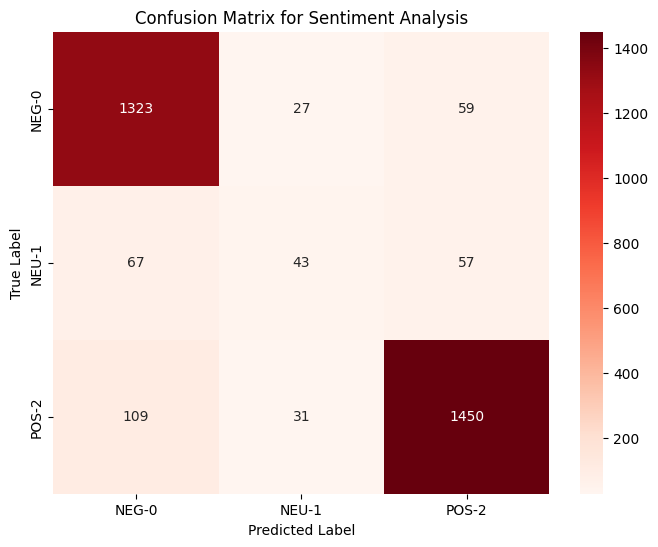

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tạo Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Thiết lập nhãn cho các lớp
labels = ["NEG-0", "NEU-1", "POS-2"]

# Vẽ Confusion Matrix bằng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Sentiment Analysis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()